### CONFIGURATION

In [1]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
import config

# --- CONFIGURATION ---
# 1. Path to your 4x images
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")



TEST_CORE = "Core_06"  # The difficult "spiderweb" core
CK_INDEX = 6 

# ALGORITHM PARAMETERS
BLUR_KERNEL = (31, 31)  # Aggressive blur to merge webs
MIN_AREA = 500          # Ignore tiny noise specks

### 1. Define Helper Functions

In [2]:
def robust_normalize(img):
    """
    Enhance faint structures so the web becomes visible.
    """
    if img.size == 0: return img
    valid = img[img > 0]
    if valid.size == 0: return img
    p_low, p_high = np.percentile(valid, (1, 99))
    norm = np.clip((img - p_low) / (p_high - p_low + 1e-5), 0, 1)
    return (norm * 255).astype(np.uint8)

def get_blob_centroid(img, debug=False):
    """
    Returns the mask and centroid of the largest tissue mass.
    """
    # 1. Normalize
    norm = robust_normalize(img)
    
    # 2. Heavy Blur (The Magic Step)
    blur = cv2.GaussianBlur(norm, BLUR_KERNEL, 0)
    
    # 3. Threshold (Otsu)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Find Largest Blob
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None, None
    
    # Get largest contour (the main tissue mass)
    largest_cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_cnt)
    
    if area < MIN_AREA: return None, None
    
    # Calculate Centroid
    M = cv2.moments(largest_cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        return mask, (cx, cy)
    
    return mask, None

### 2. Visualize "Spiderweb" vs "Solid Cloud"

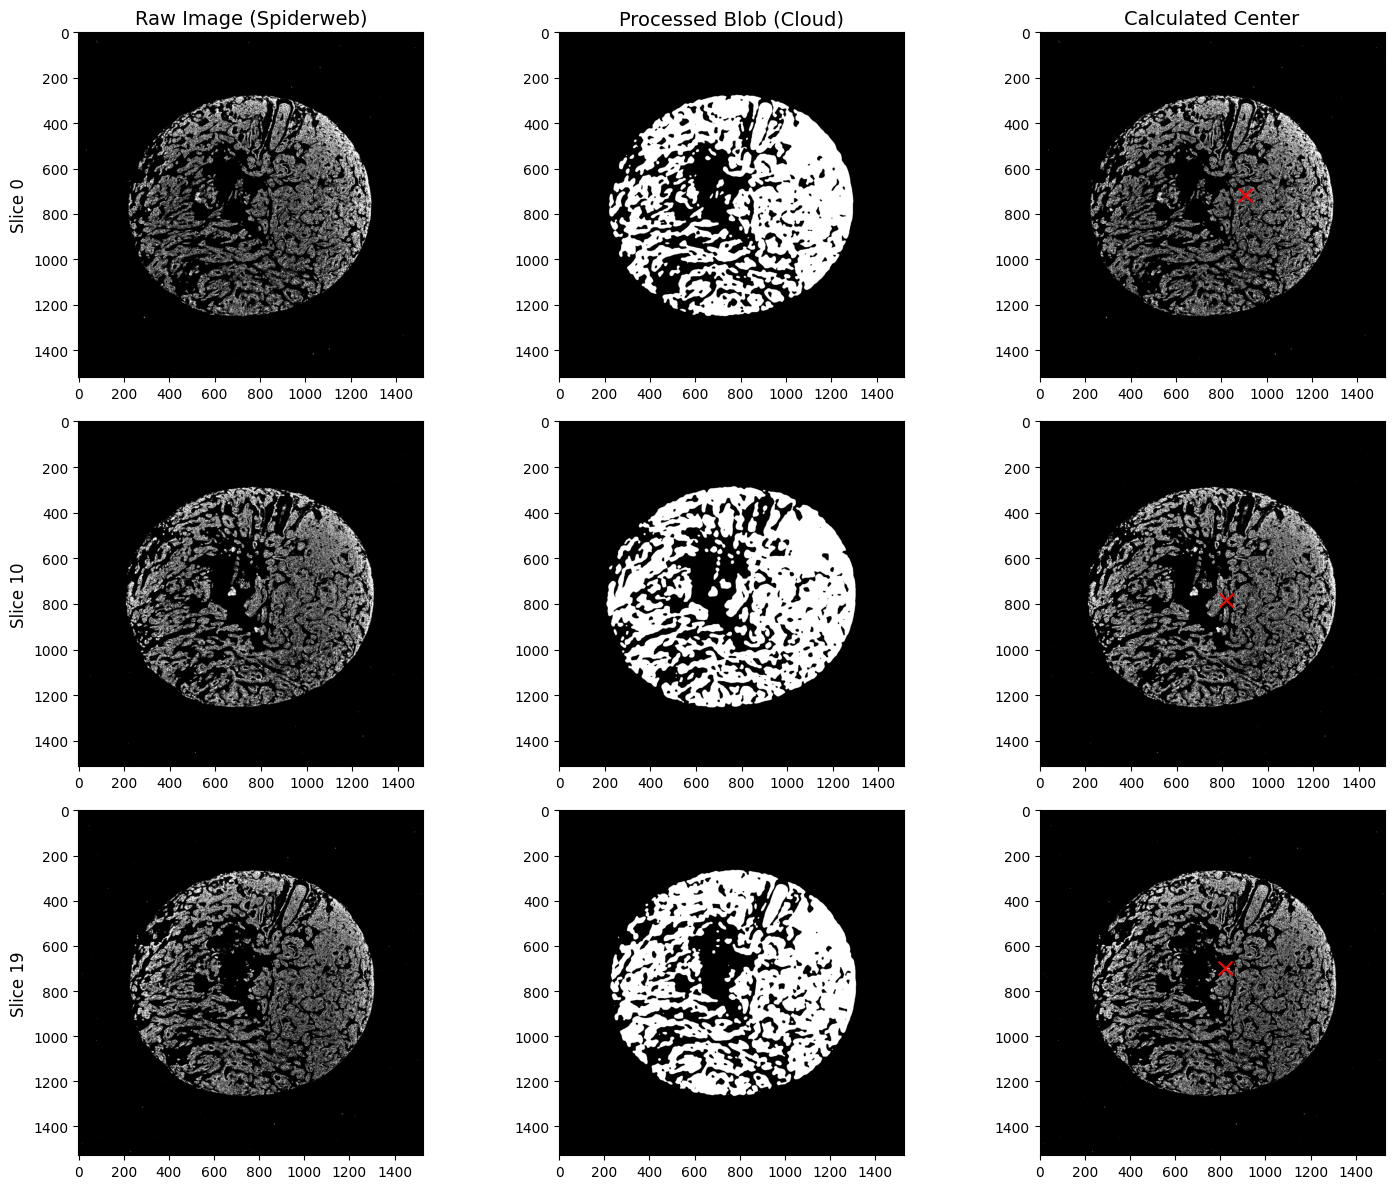

In [3]:

core_folder = os.path.join(INPUT_ROOT, TEST_CORE)
slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))

# Pick 3 equidistant slices
indices = [0, len(slice_files)//2, len(slice_files)-1]

fig, ax = plt.subplots(3, 3, figsize=(15, 12))
cols = ["Raw Image", "Heavy Blur Mask", "Centroid Location"]

for i, idx in enumerate(indices):
    fpath = slice_files[idx]
    img = tifffile.imread(fpath)
    if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
    else: ck = img[:, :, CK_INDEX]
    
    # Process
    mask, centroid = get_blob_centroid(ck)
    norm = robust_normalize(ck)
    
    # Col 1: Raw
    ax[i, 0].imshow(norm, cmap='gray')
    ax[i, 0].set_ylabel(f"Slice {idx}", fontsize=12)
    if i == 0: ax[i, 0].set_title("Raw Image (Spiderweb)", fontsize=14)
    
    # Col 2: Mask
    ax[i, 1].imshow(mask, cmap='gray')
    if i == 0: ax[i, 1].set_title("Processed Blob (Cloud)", fontsize=14)
    
    # Col 3: Centroid
    # Overlay centroid on raw image to see if it lands in the "middle"
    ax[i, 2].imshow(norm, cmap='gray')
    if centroid:
        ax[i, 2].scatter([centroid[0]], [centroid[1]], c='red', s=100, marker='x', label='Center')
    if i == 0: ax[i, 2].set_title("Calculated Center", fontsize=14)

plt.tight_layout()
plt.show()

### 3. Plot the Trajectory (Drift Analysis)

Tracking tissue center across all slices...


100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


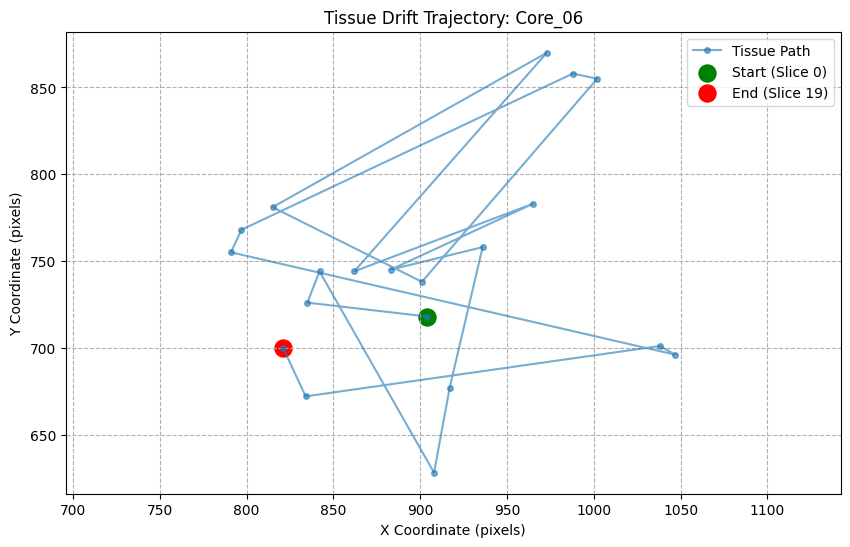

Total Displacement: X=256px, Y=242px


In [4]:
# Calculate the centroid for EVERY slice and plot the path. 
# Smooth line = Good tracking. Jagged line = Unstable.

# %%
centroids_x = []
centroids_y = []
valid_indices = []

print("Tracking tissue center across all slices...")

for idx, fpath in enumerate(tqdm(slice_files)):
    try:
        img = tifffile.imread(fpath)
        ck = img[CK_INDEX, :, :] if img.shape[0] < 20 else img[:, :, CK_INDEX]
        
        _, centroid = get_blob_centroid(ck)
        
        if centroid:
            centroids_x.append(centroid[0])
            centroids_y.append(centroid[1])
            valid_indices.append(idx)
    except:
        continue

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(centroids_x, centroids_y, '-o', markersize=4, alpha=0.6, label='Tissue Path')

# Mark Start and End
if centroids_x:
    plt.scatter([centroids_x[0]], [centroids_y[0]], c='green', s=150, label='Start (Slice 0)')
    plt.scatter([centroids_x[-1]], [centroids_y[-1]], c='red', s=150, label=f'End (Slice {valid_indices[-1]})')

plt.title(f"Tissue Drift Trajectory: {TEST_CORE}")
plt.xlabel("X Coordinate (pixels)")
plt.ylabel("Y Coordinate (pixels)")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.axis('equal') # Keep aspect ratio so we see real movement shape
plt.show()

print(f"Total Displacement: X={max(centroids_x)-min(centroids_x)}px, Y={max(centroids_y)-min(centroids_y)}px")